In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import scipy as sp
import imageio.v3 as imageio
import skimage as ski
from tqdm.auto import trange
import texture_segmentation.gabor as gabor
import texture_segmentation.diffusion as diffusion
import texture_segmentation.segment as segment
import texture_segmentation.data as data


plt.rcParams['image.cmap'] = 'gray'

In [2]:
def approximate_delta(x: NDArray, epsilon: float = 1e-6):
    divisor = np.abs(epsilon) * np.sqrt(np.pi)
    return np.exp(-x**2 / epsilon**2) / divisor

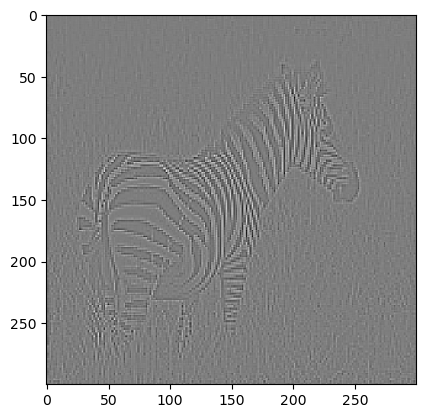

In [61]:
use_image = "zebra"
imsize = 300
backgroud_id = 53
texture_id = 77

if use_image == "brodatz":
    image = data.brodatz_test_image(backgroud_id, texture_id, imsize)
elif use_image == "sine":
    image = data.sine_wave_test_image(imsize)
elif use_image == "disk":
    image = data.disk_on_gradient_test_image(imsize)
elif use_image == "zebra":
    image = imageio.imread("zebra_1.png")
    image = image[:, 50:-50, :3]
    image = ski.color.rgb2gray(image)
    image = ski.transform.resize(image, (imsize, imsize))
else:
    raise ValueError("Invalid image")

image_o = image.copy()
image = ski.filters.laplace(image)
image -= image.mean()
image /= image.std()

plt.imshow(image)
plt.show()

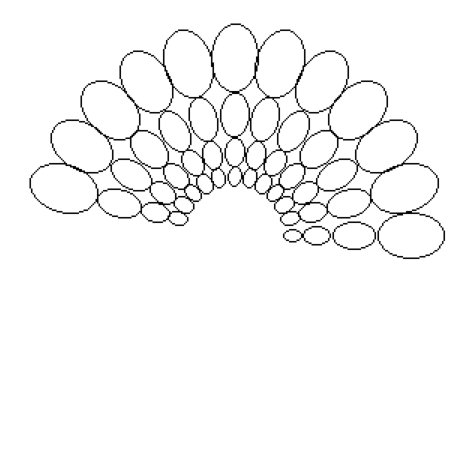

In [62]:
filter_bank_params = {
    'num_angles': 12,
    'full_circle': False,
    'scaling_factor': 0.42,
    'num_scales': 4,
    'sigma_x0': 0.13,
    "sigma_y0": 0.085
}
arr = gabor.plot_gabor_filter_bank_fft_fwhm(300, **filter_bank_params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.imshow(arr, cmap="binary")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [64]:
res = segment.segment(
    image=image,
    method=segment.SEG_METHOD.GEODESIC_SNAKES,
    feature_type=segment.FEATURE_TYPE.GABOR,
    initial_function="disk",
    it=100,
    eta=1,
    gabor_filters_params=filter_bank_params,
    lambda_c=0.6,
    mu=0.9, 
    combined_mathod=False
)

# Post-process segmentation
phi = res['phi']
phi = ski.filters.gaussian(phi, 2)

boarder = ski.segmentation.mark_boundaries(image_o, phi <= 0, color=(1, 0, 0), mode='thick')


# Display Gabor Features
gabor_features = res['gabor_features']
fig, axs = plt.subplots(
    nrows=filter_bank_params['num_scales'], 
    ncols=filter_bank_params['num_angles'], 
    figsize=(20, 8)
)
axs = axs.flatten()
for i in range(len(gabor_features)):
    axs[i].imshow(gabor_features[i], cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Display high-level features
high_level_features = res['hl_features']
fig, axs = plt.subplots(
    nrows=1, 
    ncols=high_level_features.shape[0], 
    figsize=(20, 5)
)
for i in range(high_level_features.shape[0]):
    axs[i].imshow(high_level_features[i], cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Display results
plt.imshow(boarder)
plt.axis('off')
plt.tight_layout()
plt.show()


 35%|███▌      | 7/20 [00:02<00:03,  3.45it/s]

In [60]:
# Display Gabor Features
gabor_features = res['gabor_features']
print(gabor_features.shape)

(24, 300, 300)


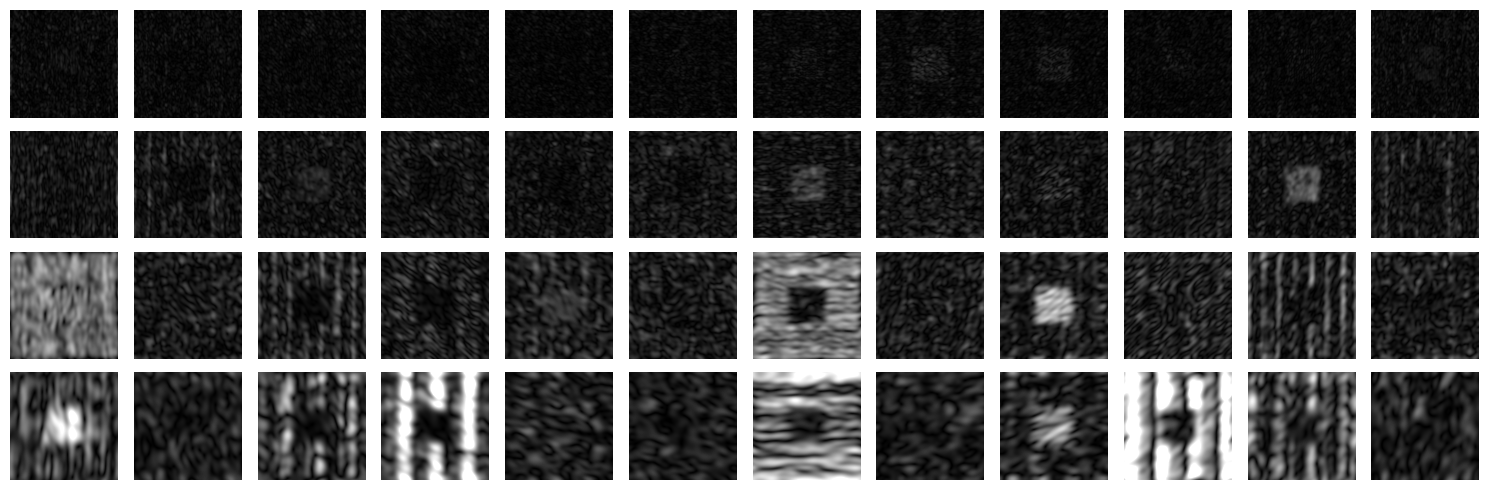

In [45]:
gabor_features_complex = gabor.gabor_features_raw(image, filter_bank_params)

# im = np.zeros((*gabor_features_complex.shape, 3), dtype=float)
# im[..., 0] = gabor_features_complex.real
# im[..., 2] = gabor_features_complex.imag

im = np.abs(gabor_features_complex)
vmin = np.quantile(im, 0.01)
vmax = np.quantile(im, 0.99)
# vmin = im.min()
# vmax = im.max()
im = im - vmin
im = im / vmax


# Plot the complex gabor features
s = 5
fig, axs = plt.subplots(nrows=im.shape[0], ncols=im.shape[1], figsize=(int(s * im.shape[1] / im.shape[0]), s))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        axs[i, j].imshow(im[i, j], vmin=0, vmax=1)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 38.92it/s]


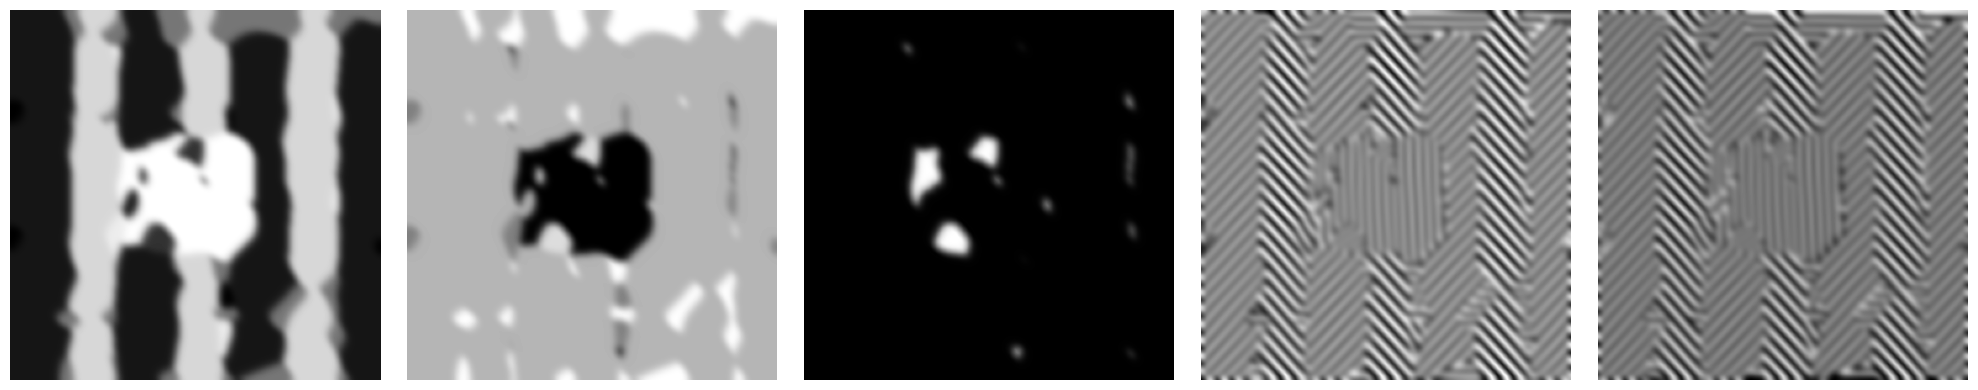

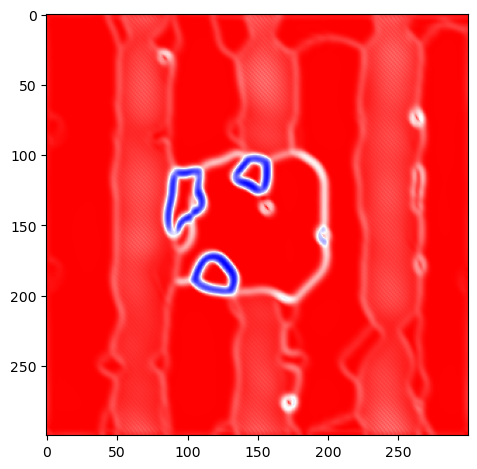

In [46]:
features, hl_features, names = gabor.gabor_features(image, filter_bank_params)
hl_features -= hl_features.mean(axis=(-2, -1), keepdims=True)
hl_features /= (hl_features.std(axis=(-2, -1), keepdims=True) + 1e-6)
hl_features_post = gabor.features_post_process(hl_features, sigma=3, diffusion_eta=0.1, diffusion_steps=20)
# hl_features_post = sp.ndimage.gaussian_filter(hl_features_post, sigma=(0, 5, 5))
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(hl_features_post[i])
    axs[i].axis("off")
plt.tight_layout()
plt.show()

g = segment.isotropic_metric(hl_features_post)
E = np.sqrt(g)
plt.imshow(E, cmap="bwr")
plt.tight_layout()
plt.show()

In [33]:
print(features.shape)

(36, 300, 300)


100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


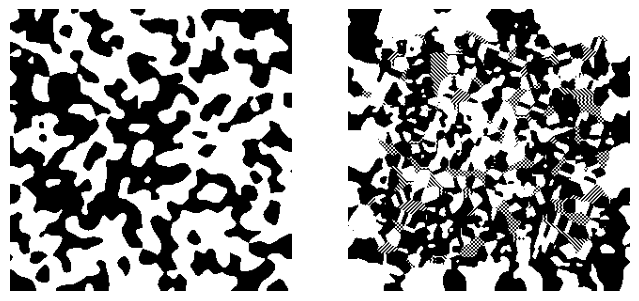

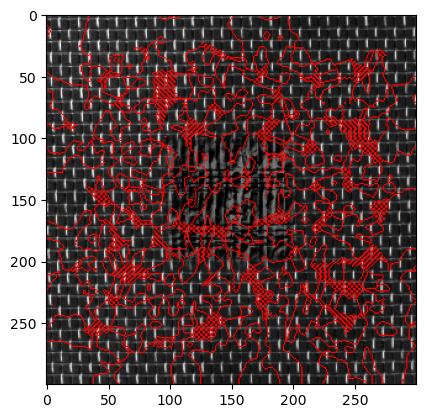

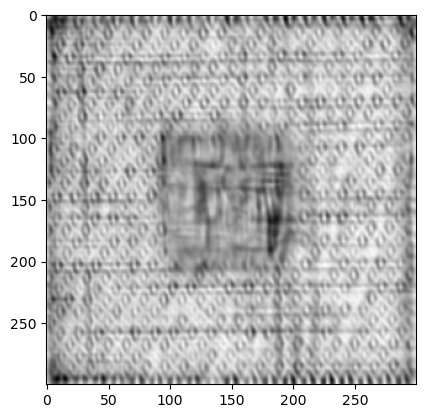

In [10]:
# phi0 = 2 * ski.segmentation.checkerboard_level_set((300, 300), 10).astype(float) - 1
phi0 = 2 * ski.segmentation.disk_level_set(image_shape=(300, 300)).astype(float) - 1
# phi0 = sp.ndimage.gaussian_filter(phi0, sigma=5)
phi0 = np.random.randn(*hl_features_post.shape[-2:]) * 0.1
phi0 = sp.ndimage.gaussian_filter(phi0, sigma=5)
feats = np.abs(gabor_features_complex).reshape(-1, imsize, imsize)
feats_post = gabor.features_post_process(feats, sigma=2, diffusion_eta=0.1, diffusion_steps=10)
# feats_post = sp.ndimage.gaussian_filter(feats_post, sigma=(0, 3, 3))
res = segment.vector_chan_vase(feats_post, phi0, eta=1, it=200, lambda_c=0.5, mu=0.8, combined_mathod=True)
# res = segment.vector_chan_vase(hl_features_post, phi0, eta=1, it=100, lambda_c=0.5, mu=0.5, combined_mathod=True)

segmented_region = 2 * (res["phi"] <= 0).astype(float) - 1
segmented_region = sp.ndimage.gaussian_filter(segmented_region, sigma=2) <=0

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].imshow(phi0 <= 0)
axs[1].imshow(segmented_region)
axs[0].axis("off")
axs[1].axis("off")
plt.show()

# phi_f = ski.segmentation.clear_border(phi_f, buffer_size=2)
bound = ski.segmentation.mark_boundaries(image_o, segmented_region, color=(1, 0, 0)).astype(float)
plt.imshow(bound)
plt.show()

plt.imshow(res["h"])
plt.show()

6229551117199453624943509504.0000; 4072563027310401048178327552.0000: 100%|██████████| 50/50 [00:00<00:00, 284.61it/s]


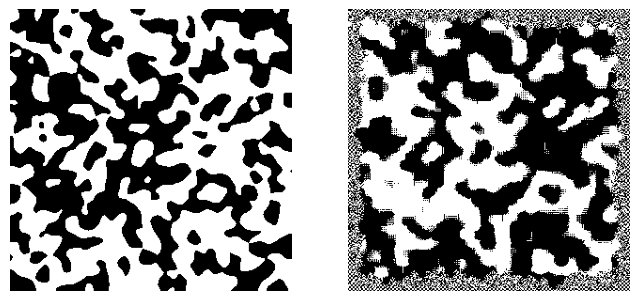

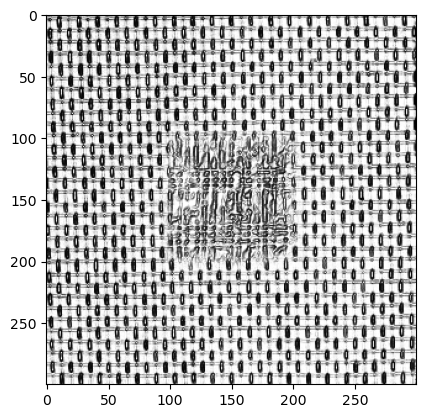

In [11]:
res = segment.deodesic_active_contours_segment(image, phi0, it=50, eta=1, c=0)
segmented_region = 2 * (res["phi"] <= 0).astype(float) - 1
segmented_region = sp.ndimage.gaussian_filter(segmented_region, sigma=0) <=0

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].imshow(phi0 <= 0)
axs[1].imshow(segmented_region)
axs[0].axis("off")
axs[1].axis("off")
plt.show()

plt.imshow(res["E"])
plt.show()


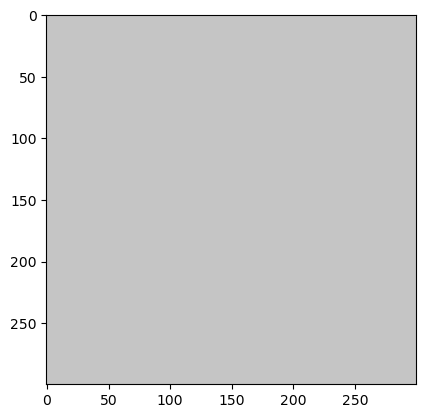

In [12]:
plt.imshow(res["step_logs"][-10])